In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lib.residental_data_source import ResidentialDataSource

In [20]:
data_source = ResidentialDataSource('src/dataset_processed.xlsx')
ds = data_source.fetch_data_set()
ds.head()

,Таргет,Всероссийский застройщик,Инфраструктура: Рядом ВУЗ,Есть железная дорога 250м,Есть ЛЭП 100м,Есть магистральные дороги 100м,Есть АЗС 100м,Есть скверы 500м,Есть лес 500м,Есть водоем 500м,...,Район_змеинка,Район_луговая,Район_нейбута,Район_патрокл,Район_первая речка,Район_снеговая падь,Район_тихая,Район_третья рабочая,Район_центр,Район_чуркин
0,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,95000.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Линейная регрессия

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
X = ds.drop(columns=['Таргет']) 
y = ds['Таргет']   

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

wape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

print('Значения метрик:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'WAPE: {wape}')

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = np.mean(-cv_scores)

print(f'Средний MAE по кросс-валидации: {mean_cv_score}')

Значения метрик:
MAE: 27309.851780315625
MSE: 1262610627.2225072
WAPE: 0.32237149240394064
Средний MAE по кросс-валидации: 3.926800182521896e+17


In [7]:
y_test.describe()

count       483.000000
mean      84715.467787
std       73404.244238
min           0.000000
25%           0.000000
50%      112287.259085
75%      141717.873846
max      277344.191097
Name: Таргет, dtype: float64

## Решающие деревья

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

In [22]:
ds['Таргет'] = pd.to_numeric(ds['Таргет'], errors='coerce')

X = ds.drop(columns=['Таргет']).apply(pd.to_numeric, errors='coerce')
y = ds['Таргет']

In [23]:
data = pd.concat([X, y], axis=1)
data = data.dropna()

X = data.drop(columns=['Таргет'])
y = data['Таргет']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 379484436.3290


In [27]:
dot_data = export_graphviz(regressor, out_file=None, 
                           feature_names=X.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree", format='png', view=True, cleanup=True)
graph.view()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.549468 to fit


'decision_tree.pdf'

## Gradient boosting

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [36]:
gbrt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbrt.fit(X_train_scaled, y_train)

y_pred_gb = gbrt.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Gradient Boosting Mean Squared Error: {mse_gb:.4f}')

r2 = r2_score(y_test, y_pred_gb)
print(f'R-squared: {r2:.4f}')


Gradient Boosting Mean Squared Error: 243670153.7678
R-squared: 0.9577


In [ ]:
feature_importances = gbrt.feature_importances_
print(f'Feature Importances:\n{feature_importances}')

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})


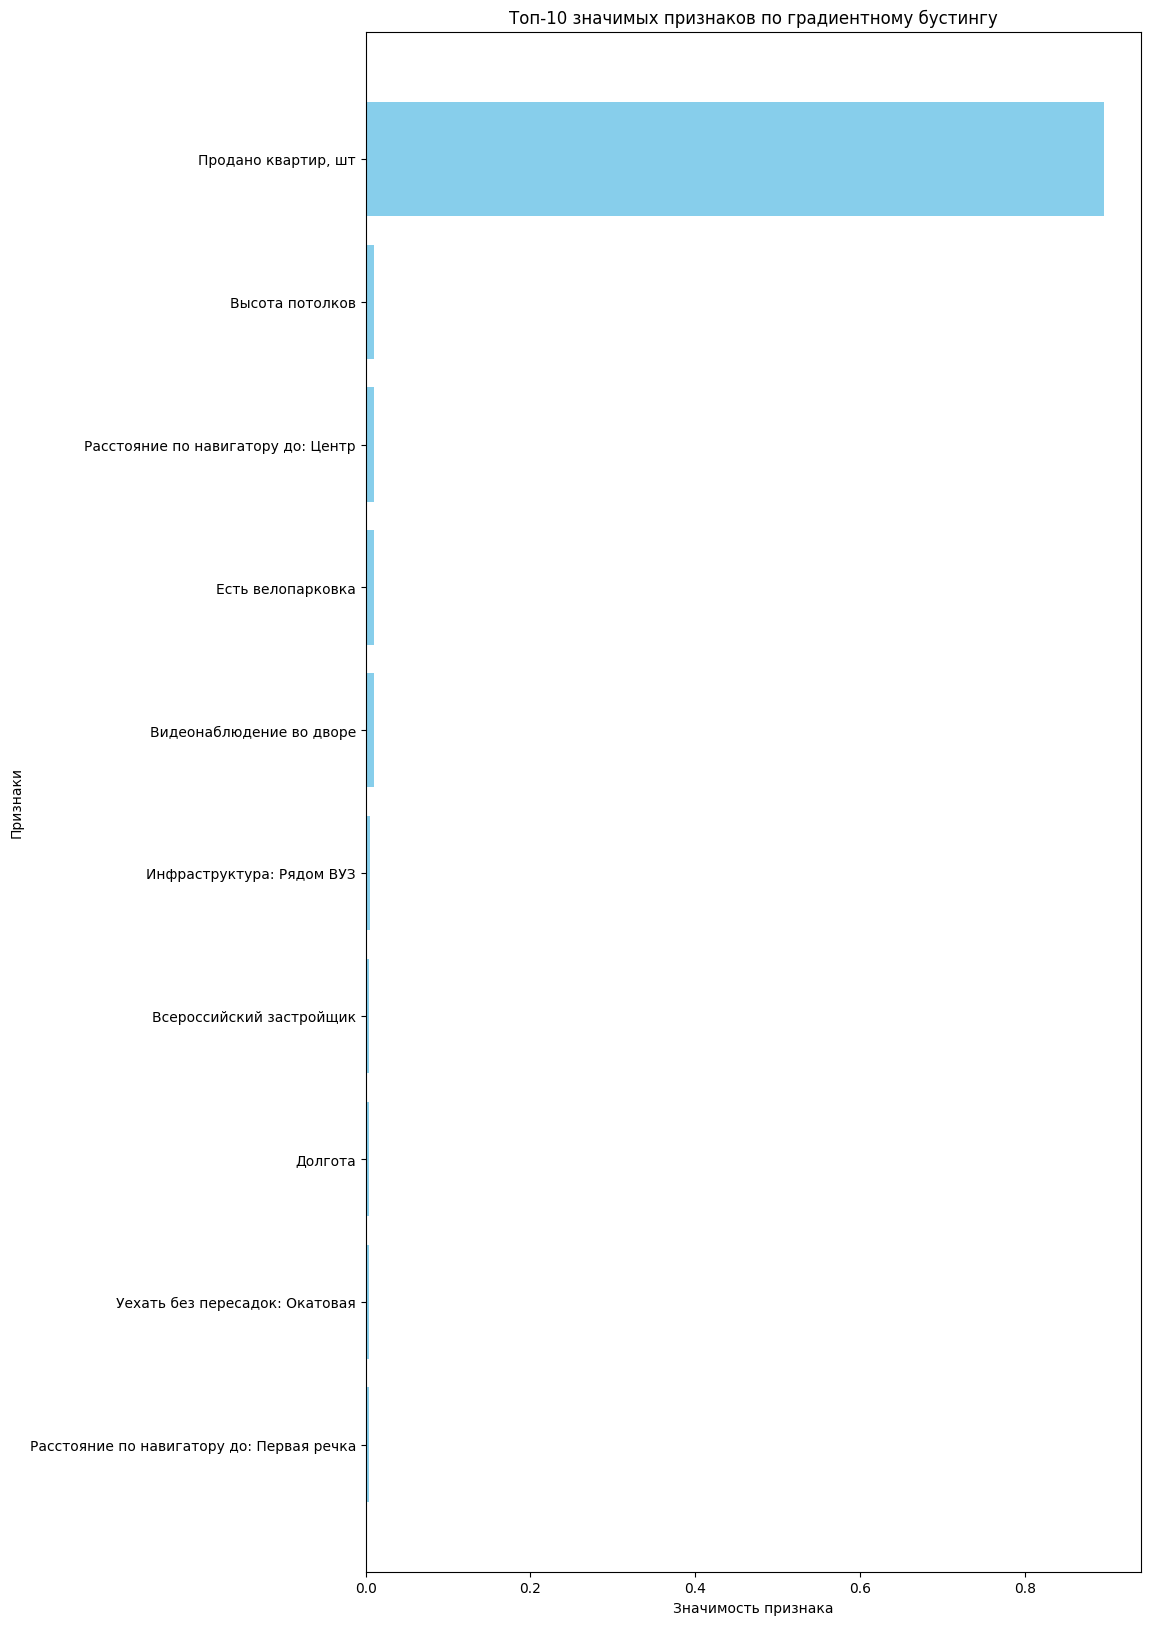

In [43]:
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Значимость признака')
plt.ylabel('Признаки')
plt.title('Топ-10 значимых признаков по градиентному бустингу')
plt.gca().invert_yaxis() 
plt.show()
